### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
# ! pip install spacy
# ! pip install torchnlp

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = './data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [4]:
import random
import math
import time

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tqdm

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from nltk.translate.bleu_score import corpus_bleu
from utils import get_text, remove_tech_tokens
from utils_ext import generate_translation_emb

from model3 import LstmEncoder, AttentionLstmDecoder, AttentionLstmSeq2Seq

model_name = 'model3.pt'

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
import fasttext
import fasttext.util

fasttext.util.download_model("ru", if_exists="ignore")
ft_ru = fasttext.load_model("cc.ru.300.bin")

In [6]:
tokenizer_W = WordPunctTokenizer()

def tokenize_rus(x, tokenizer=tokenizer_W):
    return np.vstack([ft_ru[token] for token in tokenizer.tokenize(x.lower())])

def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize_rus,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            use_vocab = False,
            lower = False)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [11]:
# SRC.build_vocab(train_data, min_freq = 2)

TRG.build_vocab(train_data, min_freq = 2)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 132 ms


In [12]:
# print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in target (en) vocabulary: 10104


And from target (EN) corpus:

In [14]:
TRG.vocab.itos[::1000]

['<unk>',
 'springs',
 'galeao',
 'calm',
 'occupies',
 'tegel',
 'malioboro',
 'athena',
 'haapsalu',
 'perdido',
 'wilpattu']

And here is example from train dataset:

In [15]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': array([[-1.9824868e-02, -7.2624758e-02,  5.2856524e-02, ...,
         2.0295117e-02, -1.9263761e-02, -1.1642285e-02],
       [-2.9869273e-02,  1.2806241e-02,  1.9077549e-02, ...,
         2.8562802e-04,  2.6774352e-02,  4.5010813e-02],
       [ 7.2850876e-02, -1.0890429e-02,  4.6358462e-03, ...,
         2.1846952e-02,  2.0648330e-02, -5.4433316e-02],
       ...,
       [-2.3778513e-02, -1.3813411e-02, -1.2311087e-02, ...,
        -4.6131127e-02, -3.1480912e-02, -2.9587111e-02],
       [ 7.2922252e-02, -1.3579302e-01, -4.1046310e-02, ...,
        -4.4682629e-02, -1.0970861e-01,  3.5256915e-02],
       [-5.5542979e-02, -1.7467838e-02,  9.3605228e-02, ...,
         2.0078627e-02,  5.3502511e-02, -3.5628927e-01]], dtype=float32)}


Let's check the length distributions:

Length distribution in Train data


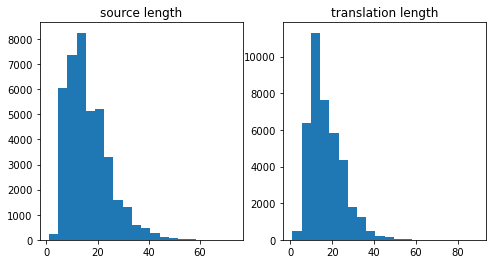

In [16]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


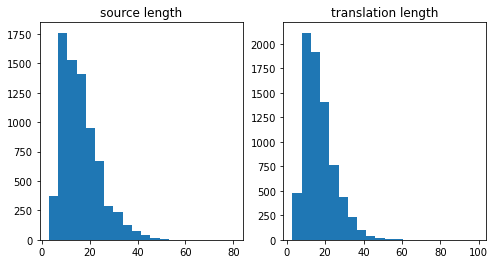

In [17]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
vars(train_data.examples[1])['src'].shape

(14, 300)

In [20]:
BATCH_SIZE = 64

def collate_fn(batch):
    res = {'src': [], 'trg': []}
    
    src_max = 0
    trg_max = 0
    
    for x in batch:
        data = vars(x)
        
        src_data = data['src']
        trg_data = data['trg']
        
        src_max = max(src_max, len(src_data))
        trg_max = max(trg_max, len(trg_data))
        
        res['src'].append(src_data)
        res['trg'].append(trg_data)
        
    src_data = np.zeros((len(batch), src_max, src_data[0].shape[-1]))
    for i, data in enumerate(res['src']):
        src_data[i, :len(data)] = data
    
    trg_data = np.ones((len(batch), trg_max + 1))
    for i, data in enumerate(res["trg"]):
        trg = [TRG.vocab.stoi[word] for word in data]
        trg.append(TRG.vocab.stoi["<eos>"])
        trg_data[i, :len(trg)] = trg
    
    res['src'] = torch.Tensor(src_data.transpose(1, 0, 2)).to(device)
    res['trg'] = torch.LongTensor(trg_data.transpose(1, 0)).to(device)
    
    return res

train_iterator = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn, 
)

valid_iterator = DataLoader(
    valid_data, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn, 
)


test_iterator = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn, 
)

for x in train_iterator:
    break
    
print(x['src'].shape, x['trg'].shape)

torch.Size([34, 64, 300]) torch.Size([40, 64])


In [21]:
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

LR = 1e-3
N_EPOCHS = 10
CLIP = 3.

enc = LstmEncoder(OUTPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionLstmDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionLstmSeq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

AttentionLstmSeq2Seq(
  (encoder): LstmEncoder(
    (rnn): LSTM(300, 512, num_layers=3, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionLstmDecoder(
    (embedding): Embedding(10104, 300)
    (attention): Attention(
      (linear_in): Linear(in_features=1536, out_features=1536, bias=False)
      (linear_out): Linear(in_features=3072, out_features=1536, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (rnn): LSTM(300, 512, num_layers=3, dropout=0.5)
    (out): Linear(in_features=1536, out_features=10104, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,378,072 trainable parameters


In [24]:
PAD_IDX = TRG.vocab.stoi['<pad>']

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [25]:
def train(model: AttentionLstmSeq2Seq, iterator, optimizer, criterion,
          clip, epoch: int, 
          train_history=None, valid_history=None, 
          train_bleu_history=None, val_bleu_history=None, ):

    model.train()
    
    epoch_loss = 0
    history = []

    teacher_forcing_ratio = 0.85 ** (epoch * 0.7  + 1)

    for i, batch in enumerate(iterator):
        
        src = batch['src']
        trg = batch['trg']

        optimizer.zero_grad()
        
        output = model.forward(src, trg, teacher_forcing_ratio)
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].contiguous().view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%50==0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            if train_bleu_history is not None:
                ax[2].plot(train_bleu_history, label='train BLEU history')
            if val_bleu_history is not None:
                ax[2].plot(val_bleu_history, label='validate BLEU history')

            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Validation loss')

            ax[2].set_xlabel('Epoch')
            ax[2].set_title('BLEU')
                
            plt.legend()
            plt.show()

        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch['src']
            trg = batch['trg']

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].contiguous().view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [27]:
def calc_bleu(model, iterator, hidden_tqdm = False):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(iterator), disable=hidden_tqdm):

            src = batch['src']
            trg = batch['trg']

            output = model(src, trg, 0) #turn off teacher forcing

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
            
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [28]:
def epoch_time(start_time, end_time, epoch: int=1):
    elapsed_time = (end_time - start_time) / epoch
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

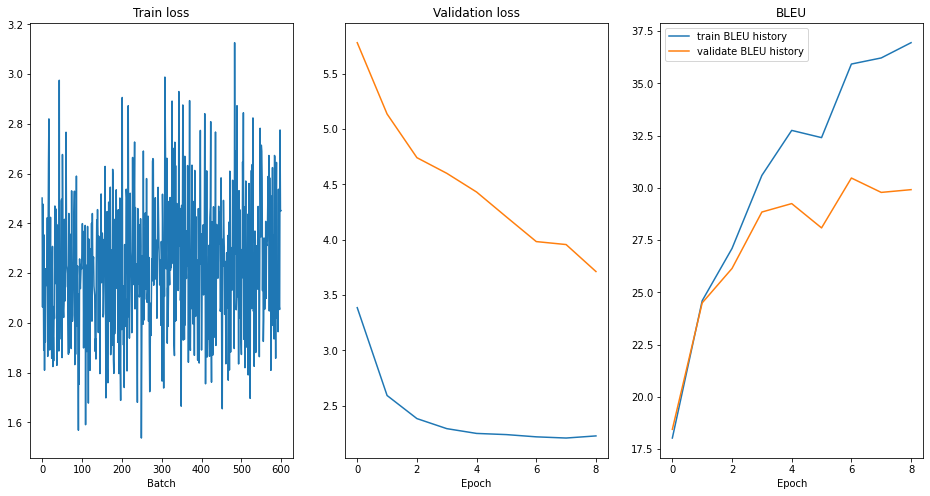

Total epohs: 10
Total train time: Time: 46m 47s
Average epoch train time: 4m 40s
Best BLEU:  30.471


In [29]:
train_history = []
valid_history = []
train_bleu_history = []
val_bleu_history = []

best_valid_bleu = float('-inf')

start_time = time.time()

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, epoch,
                       train_history, valid_history, train_bleu_history, val_bleu_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_bleu = calc_bleu(model, train_iterator, hidden_tqdm=True)
    valid_bleu = calc_bleu(model, valid_iterator, hidden_tqdm=True)
    if valid_bleu > best_valid_bleu:
        best_valid_bleu = valid_bleu
        torch.save(model.state_dict(), model_name)
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    train_bleu_history.append(train_bleu)
    val_bleu_history.append(valid_bleu)

end_time = time.time()

print(f'Total epohs: {epoch+1:02}')

epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Total train time: Time: {epoch_mins}m {epoch_secs}s')

epoch_mins, epoch_secs = epoch_time(start_time, end_time, N_EPOCHS)
print(f'Average epoch train time: {epoch_mins}m {epoch_secs}s')

print(f'Best BLEU: {best_valid_bleu:7.3f}')

__Let's take a look at our network quality__:

In [30]:
enc = LstmEncoder(OUTPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionLstmDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionLstmSeq2Seq(enc, dec, device).to(device)

model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [31]:
batch = next(iter(test_iterator))
for idx in range(50, 55):
    src = batch['src'][:, idx:idx+1]
    trg = batch['trg'][:, idx:idx+1]
    generate_translation_emb(src, trg, model, TRG.vocab)

Translation:	dorms feature individual curtains for privacy .
Generated:	have individual lockers .

Translation:	featuring free wifi and a barbecue , mini - hotel offers pet - friendly accommodation in . guests can enjoy the on - site bar .
Generated:	free wifi , barbecue facilities , offers pet - friendly accommodation in adler .

Translation:	there is a shared kitchen at the property .
Generated:	is a shared kitchen at the property .

Translation:	the nearest airport is tbilisi international airport , 11 km from apartment at .
Generated:	nearest airport is pulkovo international airport , 11 km from apartment on .

Translation:	the city of is 24 minutes ' drive away .
Generated:	town of kastoria is a 24 - minute drive away .



In [32]:
calc_bleu(model, test_iterator)

118it [00:11, 10.55it/s]


29.828964851971463

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points